## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [889]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [890]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [891]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [892]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [893]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [894]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [895]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [896]:
# save the data set

data.to_csv('titanic.csv', index=False)

In [897]:
data.shape

(1309, 10)

## Data Exploration

### Find numerical and categorical variables

In [898]:
target = 'survived'

In [899]:
data_types = data.dtypes
vars_num = list(data_types[data_types != 'object'].index)
vars_cat = list(data_types[data_types == 'object'].index)
vars_num.remove('survived')

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [900]:
# first in numerical variables
missing_values_num = data[vars_num].isnull().sum()
missing_values_num
missing_values_pct_num = missing_values_num / len(data) * 100
missing_values_pct_num


pclass     0.000000
age       20.091673
sibsp      0.000000
parch      0.000000
fare       0.076394
dtype: float64

In [901]:
# now in categorical variables
missing_values_cat = data[vars_cat].isnull().sum()
missing_values_cat
missing_values_pct_cat = missing_values_cat / len(data) * 100
missing_values_pct_cat


sex          0.000000
cabin       77.463713
embarked     0.152788
title        0.000000
dtype: float64

### Determine cardinality of categorical variables

In [902]:
for col in vars_cat:
    unique_vals = data[col].nunique()
    print(f"{col} has {unique_vals} unique values.")

sex has 2 unique values.
cabin has 181 unique values.
embarked has 3 unique values.
title has 5 unique values.


### Determine the distribution of numerical variables

In [903]:
def vars_num_stats(a):
    for var in vars_num:
        mean_val = data[var].mean()
        median_val = data[var].median()
        std_val = data[var].std()
        print(f"{var} - mean: {mean_val}, median: {median_val}, std: {std_val}")
# calculate mean, median, and standard deviation of each numerical variable

vars_num_stats(vars_num)



pclass - mean: 2.294881588999236, median: 3.0, std: 0.837836018970131
age - mean: 29.8811345124283, median: 28.0, std: 14.413499699923594
sibsp - mean: 0.4988540870893812, median: 0.0, std: 1.0416583905961017
parch - mean: 0.3850267379679144, median: 0.0, std: 0.8655602753495126
fare - mean: 33.29547928134572, median: 14.4542, std: 51.758668239174135


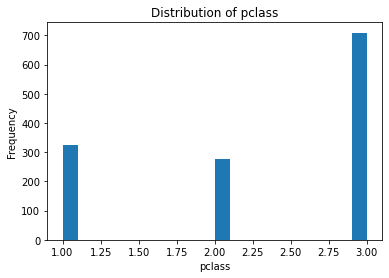

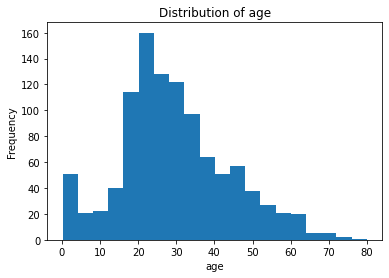

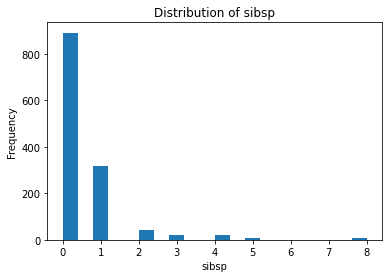

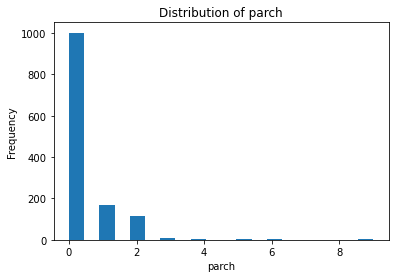

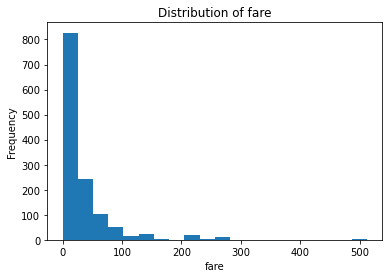

In [904]:
#Plotting histogram

# loop through numerical variables and plot histogram
for var in vars_num:
    plt.hist(data[var], bins=20)
    plt.title('Distribution of ' + var)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [905]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

In [906]:
y_train.shape, y_test.shape
y_train.head()

1118    0
44      1
1072    0
1130    0
574     0
Name: survived, dtype: int64

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [907]:

X_train['cabin'] = X_train['cabin'].str.replace('\d+', '').str[0]
X_test['cabin'] = X_test['cabin'].str.replace('\d+', '').str[0]

X_train['cabin'].unique()

/var/folders/q0/ly0zq6b53sj63t8g3vk65zv40000gn/T/ipykernel_10878/2920960786.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  X_train['cabin'] = X_train['cabin'].str.replace('\d+', '').str[0]
/var/folders/q0/ly0zq6b53sj63t8g3vk65zv40000gn/T/ipykernel_10878/2920960786.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  X_test['cabin'] = X_test['cabin'].str.replace('\d+', '').str[0]


array([nan, 'E', 'F', 'A', 'C', 'D', 'B', 'T', 'G'], dtype=object)

In [908]:
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1139,3,male,38.0,0,0,7.8958,NaN,S,Mr
533,2,female,21.0,0,1,21.0000,NaN,S,Miss
459,2,male,42.0,1,0,27.0000,NaN,S,Mr
1150,3,male,NaN,0,0,14.5000,NaN,S,Mr
393,2,male,25.0,0,0,31.5000,NaN,S,Mr


In [909]:
X_train.isnull().sum()


pclass        0
sex           0
age         206
sibsp         0
parch         0
fare          1
cabin       803
embarked      2
title         0
dtype: int64

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [910]:

for var in ['age','fare']:
    
    X_train[var+ 'Missing'] = np.where(X_train[var].isnull(),1,0)
    X_test[var+'Missing'] = np.where(X_test[var].isnull(),1,0)
  
    X_train[var] = X_train[var].fillna(X_train[var].median())
    X_test[var] = X_test[var].fillna(X_test[var].median())
  
    
X_train [['age','fare']].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [911]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

In [912]:
X_train.isnull().sum()

pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
cabin          0
embarked       0
title          0
ageMissing     0
fareMissing    0
dtype: int64

In [913]:
X_test.isnull().sum()

pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
cabin          0
embarked       0
title          0
ageMissing     0
fareMissing    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [914]:
# loop over categorical variables
for var in vars_cat:
    
    # calculate the percentage of passengers in each label
    label_perc = X_train[var].value_counts() / len(X_train)
    
    # get list of labels to remove
    labels_to_remove = label_perc[label_perc < 0.05].index.tolist()
    
    # replace rare labels with "Other"
    X_train[var] = X_train[var].apply(lambda x: "Other" if x in labels_to_remove else x)


In [915]:
# loop over categorical variables
for var in vars_cat:
    
    # calculate the percentage of passengers in each label
    label_perc = X_test[var].value_counts() / len(X_test)
    
    # get list of labels to remove
    labels_to_remove = label_perc[label_perc <=  0.055].index.tolist()
    
    # replace rare labels with "Other"
    X_test[var] = X_test[var].apply(lambda x: "Other" if x in labels_to_remove else x)

In [916]:
X_train[vars_cat].nunique()


sex         2
cabin       3
embarked    4
title       4
dtype: int64

In [917]:
X_test[vars_cat].nunique()


sex         2
cabin       3
embarked    3
title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [918]:
# create binary variables for categorical variables
for var in vars_cat:
    X_train_dummies = pd.get_dummies(X_train[var], prefix=var, drop_first=True)
    X_test_dummies = pd.get_dummies(X_test[var], prefix=var, drop_first=True)

    # concatenate the new variables with the training and test sets
    X_train = pd.concat([X_train, X_train_dummies], axis=1)
    X_test = pd.concat([X_test, X_test_dummies], axis=1)

# drop the original categorical variables from the training and test sets
X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_test.drop(labels=vars_cat, axis=1, inplace=True)

# print the shapes of the new training and test sets
print(X_train.shape, X_test.shape)

(1047, 16) (262, 15)


In [919]:
X_train.head()


,pclass,age,sibsp,parch,fare,ageMissing,fareMissing,sex_male,cabin_Missing,cabin_Other,embarked_Other,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Other
1118,3,25.0,0,0,7.9250,0,0,1,1,0,0,0,1,1,0,0
44,1,41.0,0,0,134.5000,0,0,0,0,1,0,0,0,0,0,0
1072,3,28.0,0,0,7.7333,1,0,1,1,0,0,1,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,0,1,0,0,0,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,1,1,0,0,0,1,1,0,0


In [920]:
X_test.head()


,pclass,age,sibsp,parch,fare,ageMissing,fareMissing,sex_male,cabin_Missing,cabin_Other,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Other
1139,3,38.0,0,0,7.8958,0,0,1,1,0,0,1,1,0,0
533,2,21.0,0,1,21.0000,0,0,0,1,0,0,1,0,0,0
459,2,42.0,1,0,27.0000,0,0,1,1,0,0,1,1,0,0
1150,3,26.0,0,0,14.5000,1,0,1,1,0,0,1,1,0,0
393,2,25.0,0,0,31.5000,0,0,1,1,0,0,1,1,0,0


In [921]:
X_test['embarked_Other'] = 0

var_name_new = [c  for c in X_train.columns]

var_name_new

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'ageMissing',
 'fareMissing',
 'sex_male',
 'cabin_Missing',
 'cabin_Other',
 'embarked_Other',
 'embarked_Q',
 'embarked_S',
 'title_Mr',
 'title_Mrs',
 'title_Other']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [922]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[var_name_new]) 

# transform the train and test set
X_train = scaler.transform(X_train[var_name_new])

X_test = scaler.transform(X_test[var_name_new])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [923]:
# set up the model
# remember to set the random_state / seed

model = LogisticRegression(C=0.0005, random_state=0)

# train the model
model.fit(X_train, y_train)
LogisticRegression(C=0.0005, random_state=0)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

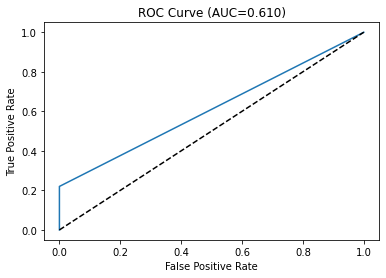

In [924]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC={:.3f})'.format(auc_score))
plt.show()

In [925]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8431723338485316
train accuracy: 0.7125119388729704

test roc-auc: 0.8358333333333333
test accuracy: 0.7022900763358778



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**